# Models: Generalized Matrix Factorization (GMF)

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
BASE_PATH             = '../..'
LIB_PATH              = f'{BASE_PATH}/lib'
DATASET_PATH          = f'{BASE_PATH}/datasets'
STACKING_PATH         = f'{DATASET_PATH}/stacking'
WEIGHTS_PATH          = f'{BASE_PATH}/weights'

METRICS_PATH          = f'{BASE_PATH}/metrics/gmf'
STACKING_TRAIN_PATH = f'{STACKING_PATH}/gmf_train.json'
STACKING_TEST_PATH  = f'{STACKING_PATH}/gmf_test.json'

In [23]:
import sys
sys.path.append(LIB_PATH)

import numpy as np
import pandas as pd
from bunch import Bunch

import torch
from torch.utils.data import DataLoader, Subset
from torch.optim import SparseAdam, Adam
from sklearn.metrics import roc_auc_score

import pytorch_common.util as pu
from pytorch_common.modules.fn import Fn
from pytorch_common.callbacks import EarlyStop, \
                                     ReduceLROnPlateau, \
                                     Validation, \
                                     SaveBestModel
from pytorch_common.callbacks.output import Logger, \
                                            MetricsPlotter

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import data as dt

import logging
import random

import util as ut

## Setup

In [24]:
ut.mkdir(STACKING_PATH)

'../../datasets/stacking'

In [25]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [26]:
import pytorch_common
pytorch_common.__version__

'0.3.8'

In [27]:
torch.__version__

'2.0.1+cu118'

In [28]:
pu.set_device_name('gpu')
cpu = torch.device("cpu")

pu.get_device(), torch.cuda.is_available()

(device(type='cuda', index=0), True)

In [29]:
ut.set_seed(42)

In [30]:
TRAIN = True

In [31]:
def get_stacking_df(model, ds, dl):
    predictions = model.evaluate(dl)
    return pd.DataFrame({
        'user_id'	 : ds.data['user_id'],
        'movie_id'   : ds.data['movie_id'],
        'rating'     : predictions[1].flatten().numpy(),
        'prediction' : predictions[0].numpy()
    })

In [32]:
def to_dl(train_set, eval_set, test_set, params):
    train_dl = DataLoader(train_set, params.batch_size, num_workers=params.n_workers, pin_memory=True, shuffle = True)
    eval_dl  = DataLoader(eval_set,  params.batch_size, num_workers=params.n_workers, pin_memory=True)
    test_dl  = DataLoader(test_set,  params.batch_size, num_workers=params.n_workers, pin_memory=True)
    return train_dl, eval_dl, test_dl

In [33]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

## Carga de dataset

In [34]:
dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    path             = DATASET_PATH,
    transform        = features_fn,
    target_transform = target_fn,
    device           = torch.device('cpu'),
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 2004)]
)

train_set, eval_test_set, rating_mean_df, rating_std = dataset.train_test_split(split_year=2016)

eval_set, test_set, _, _ = eval_test_set.train_test_split(
    split_year     = 2018, 
    rating_mean_df = rating_mean_df, 
    rating_std     = rating_std
)

train_set.shape, eval_set.shape, test_set.shape

2023-11-04 10:25:39,369 - INFO - Train: 64.81 % - Test: 8.60 %
2023-11-04 10:25:39,369 - INFO - Train: 64.81 % - Test: 8.60 %
2023-11-04 10:25:39,453 - INFO - Train: 56.64 % - Test: 27.82 %
2023-11-04 10:25:39,453 - INFO - Train: 56.64 % - Test: 27.82 %


((125905, 18), (9460, 18), (4647, 18))

## Definicion del modelo

In [35]:
params = Bunch({
    'lr'             : 0.001,
    'lr_factor'      : 0.05,
    'lr_patience'    : 3,
    'epochs'         : 12,
    'embedding_size' : 50,
    'n_workers'      : 24,
    'batch_size'     : 64,
    'n_users'        : len(dataset.features_uniques[0]),
    'n_items'        : len(dataset.features_uniques[1])
})

In [36]:
model = ml.GMF(
    n_users        = params.n_users,
    n_items        = params.n_items,
    embedding_size = params.embedding_size
).to(pu.get_device())
model

GMF(
  (embedding): MultiFeatureEmbedding(
    (embedding): Embedding(31625, 50)
  )
  (dot): BatchDot()
)

## Entrenamiento del modelo

In [37]:
train_dl, eval_dl, test_dl = to_dl(train_set, eval_set, test_set, params)

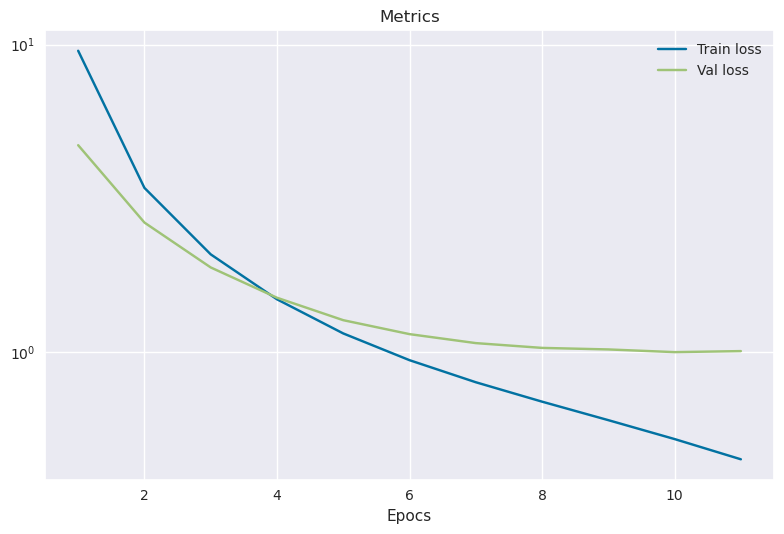

2023-11-04 10:26:59,640 - INFO - {'time': '0:00:06.72', 'epoch': 12, 'train_loss': 0.3786613071125334, 'val_loss': 1.0348457098007202, 'lr': 0.001}
2023-11-04 10:26:59,640 - INFO - {'time': '0:00:06.72', 'epoch': 12, 'train_loss': 0.3786613071125334, 'val_loss': 1.0348457098007202, 'lr': 0.001}


In [38]:
if TRAIN:
    result = model.fit(
        train_dl,
        epochs      = params.epochs,
        loss_fn     = ml.MSELossFn(),
        optimizer   = Adam(
            params       = model.parameters(),
            lr           = params.lr
        ),
        callbacks   = [
            Validation(
                eval_dl,
                metrics       = { 'val_loss': ml.MSELossFn(float_result=True)},
                each_n_epochs = 1
            ),
            ReduceLROnPlateau(metric='val_loss', mode='min', factor=params.lr_factor, patience=params.lr_patience),
            MetricsPlotter(metrics=['train_loss', 'val_loss'], plot_each_n_epochs=2),
            Logger(['time', 'epoch', 'train_loss', 'val_loss', 'patience', 'lr']),
            SaveBestModel(metric='val_loss', path=WEIGHTS_PATH, experiment_name='gfm')
        ]
    )

## Stacking dataset

Se realiza la prediccion del modelo sobre el conjunto de evaluacion, el cual sera el conjunto de entrenamiento para el meta-modelo del stacking.

In [39]:
model.load(f'{WEIGHTS_PATH}/2023-11-04_10-26-46--gfm--epoch_10--val_loss_0.9969356060028076')

2023-04-11_21-04-00--gfm--epoch_13--val_loss_0.957846462726593## Metricas sobre el conjunto de validación

In [40]:
ut.save_df(get_stacking_df(model, eval_set, eval_dl), STACKING_TRAIN_PATH)
ut.save_df(get_stacking_df(model, test_set, test_dl), STACKING_TEST_PATH)

### Metricas sobre el conjunto de validación

In [41]:
n_classes = len(dataset.target_uniques)

validator = ml.Validator(
    n_samples  = 500,
    batch_size = 10000,
    metrics    = [
        mt.RMSE(),
        mt.MeanNdcgAtk            (k=5),
        mt.MeanAveragePrecisionAtk(k=5, discretizer=dr.between(4, 5)),
        mt.MeanUserFBetaScoreAtk  (k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),
        mt.MeanUserPrecisionAtk   (k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),
        mt.MeanUserRecallAtk      (k=5, n_classes=n_classes, discretizer=dr.between(4, 5))
    ],
    predictors = [ml.ModulePredictor(model)]
)

summary = validator.validate(eval_set)
summary.save(METRICS_PATH)

Processing:   0%|          | 0/500 [00:00<?, ?it/s]

In [42]:
summary = ml.ValidatorSummary.load(METRICS_PATH)
summary.show()

Ordered by mAP@5(4,5):


,sample,RMSE,mNDCG@5,"mAP@5(4,5)","MeanUserF1.0Score@5(4,5)","Precision@5(4,5)","Recall@5(4,5)"
predictor,,,,,,,
GMF,249.5,0.99781,0.960687,0.430382,0.652795,0.652843,0.652494


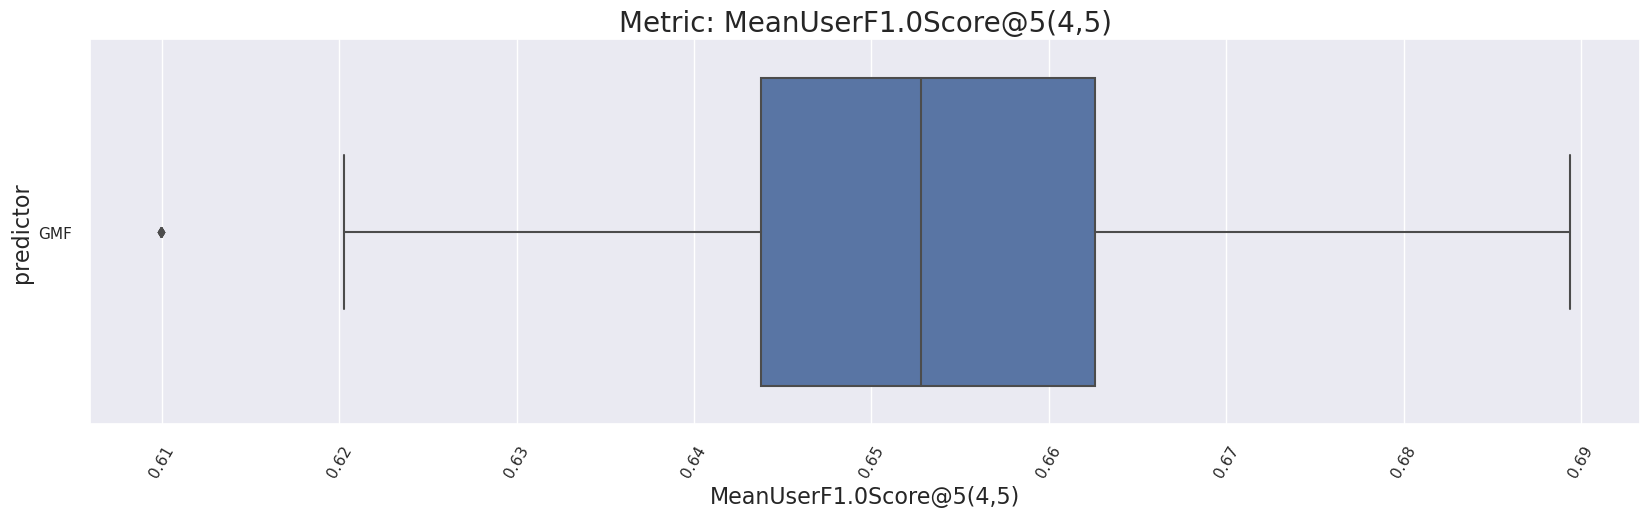

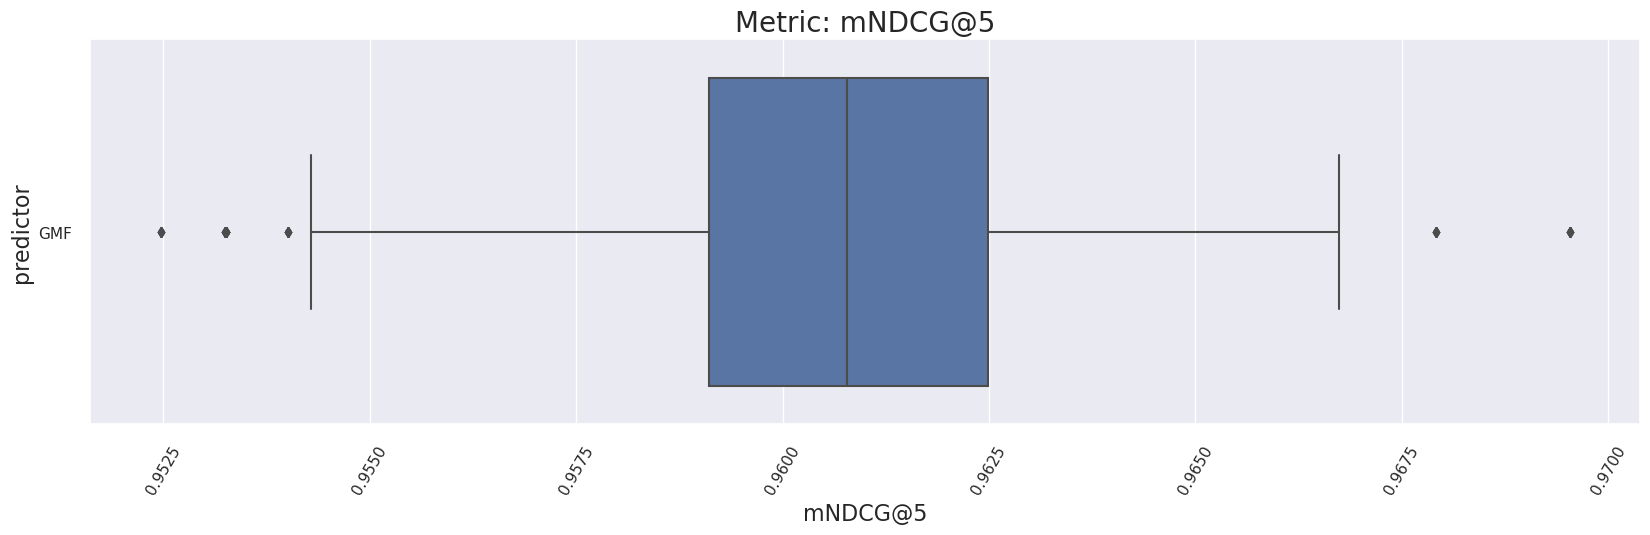

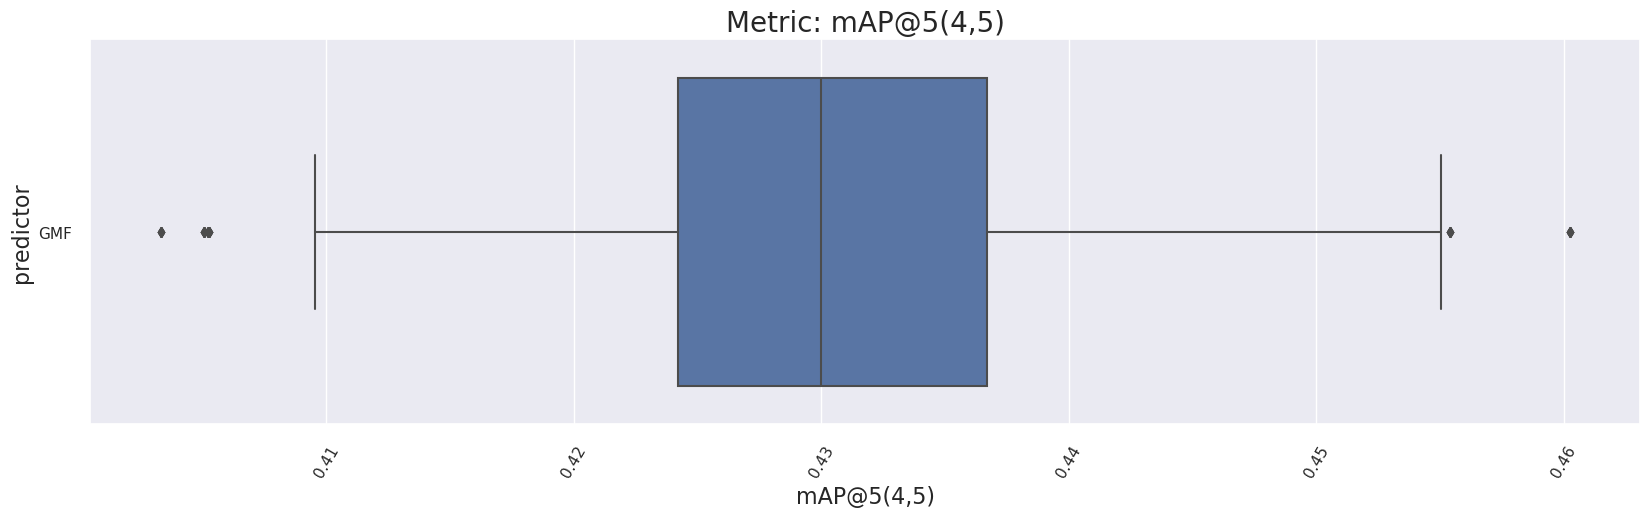

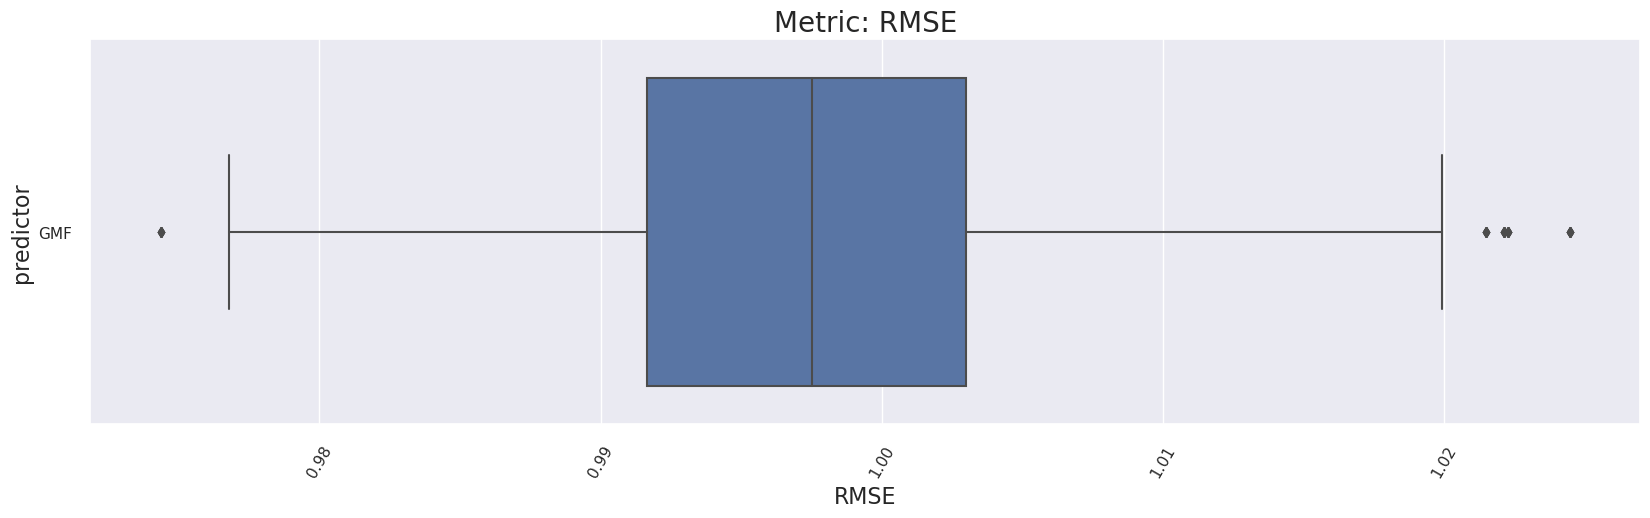

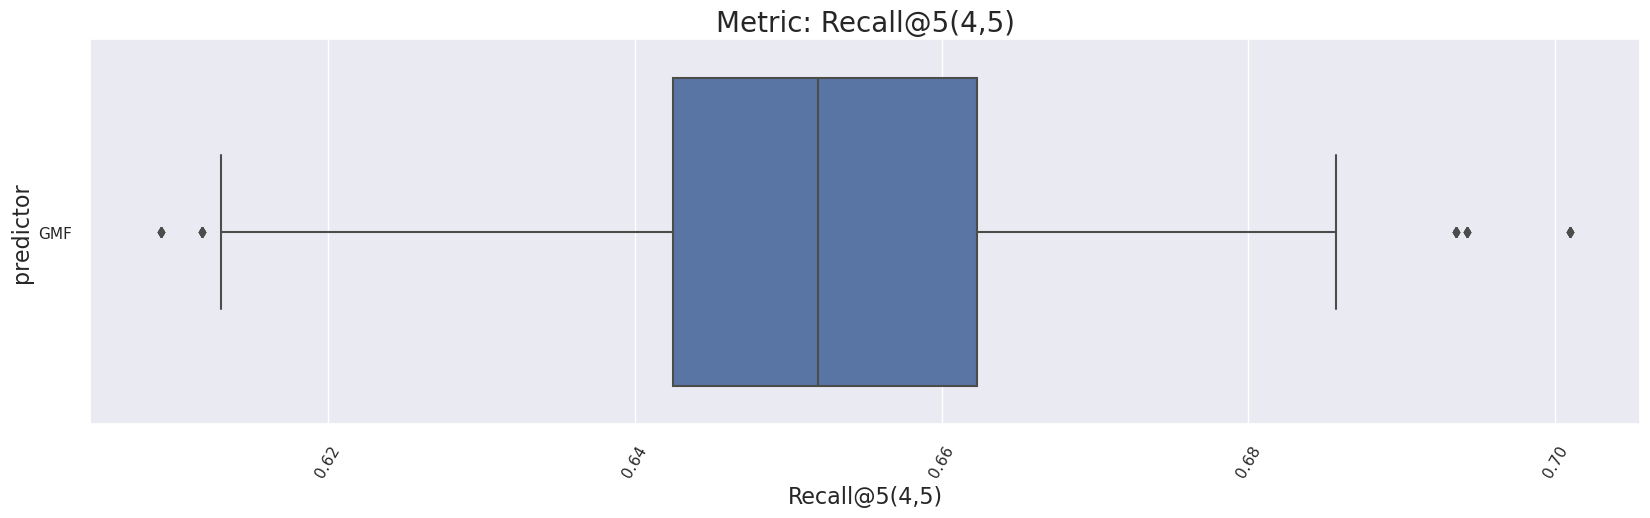

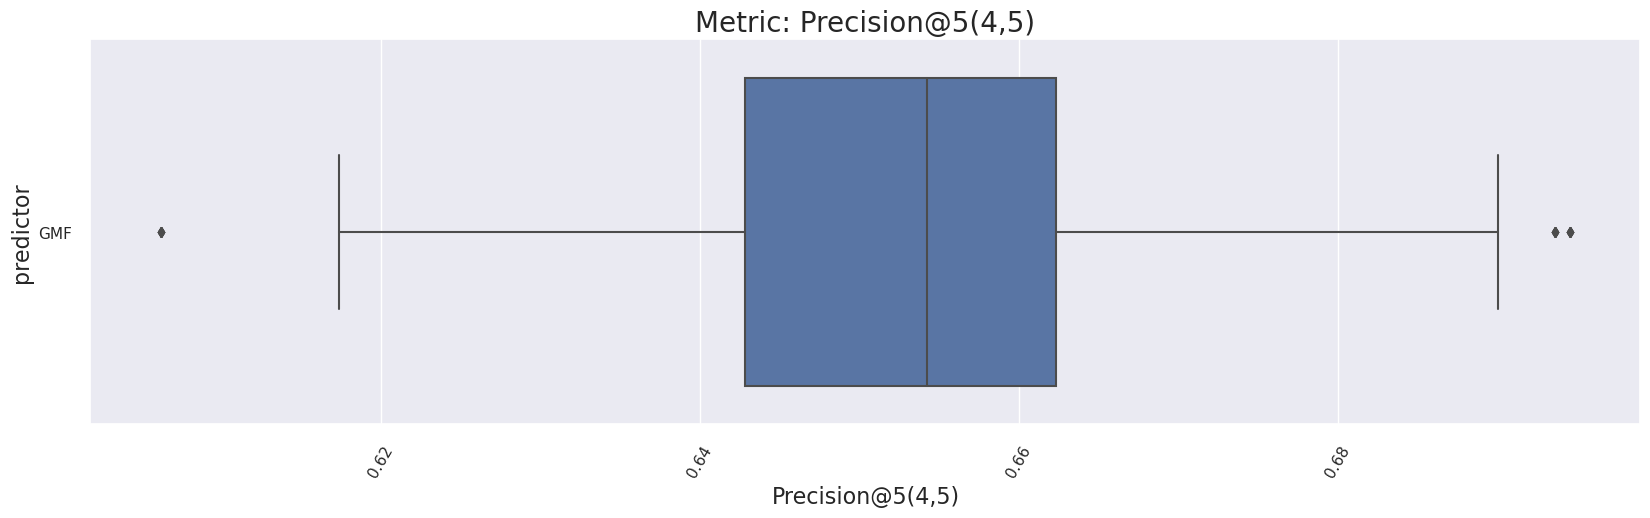

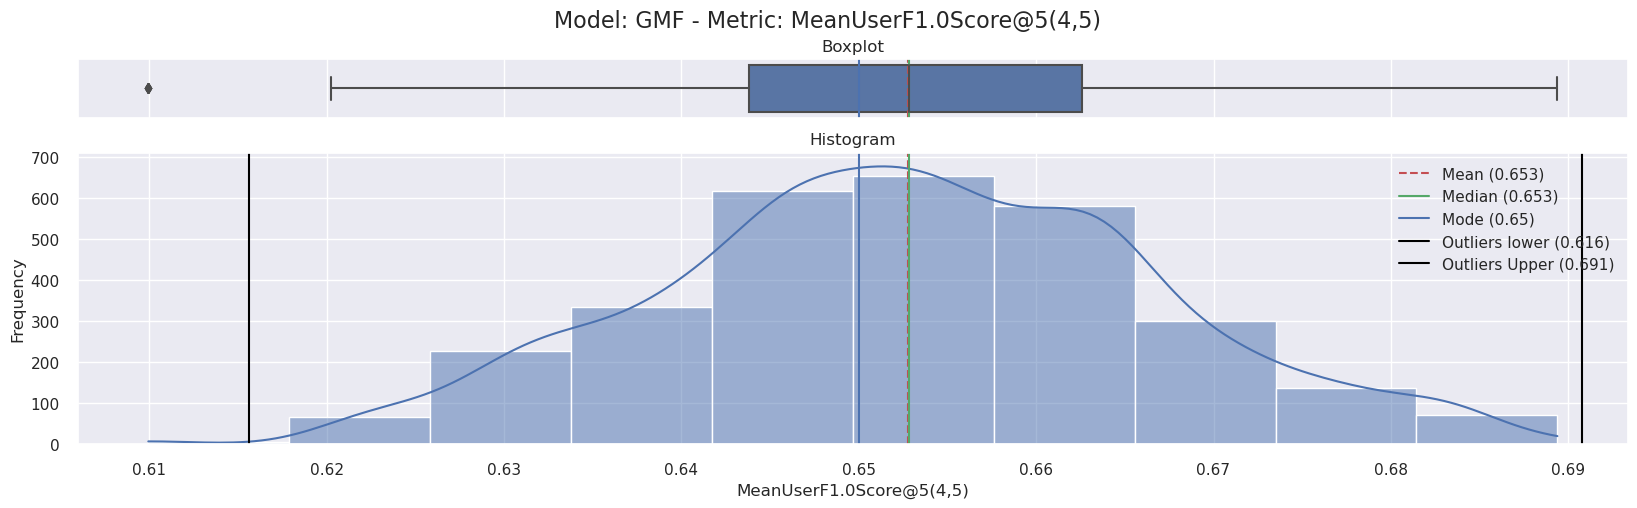

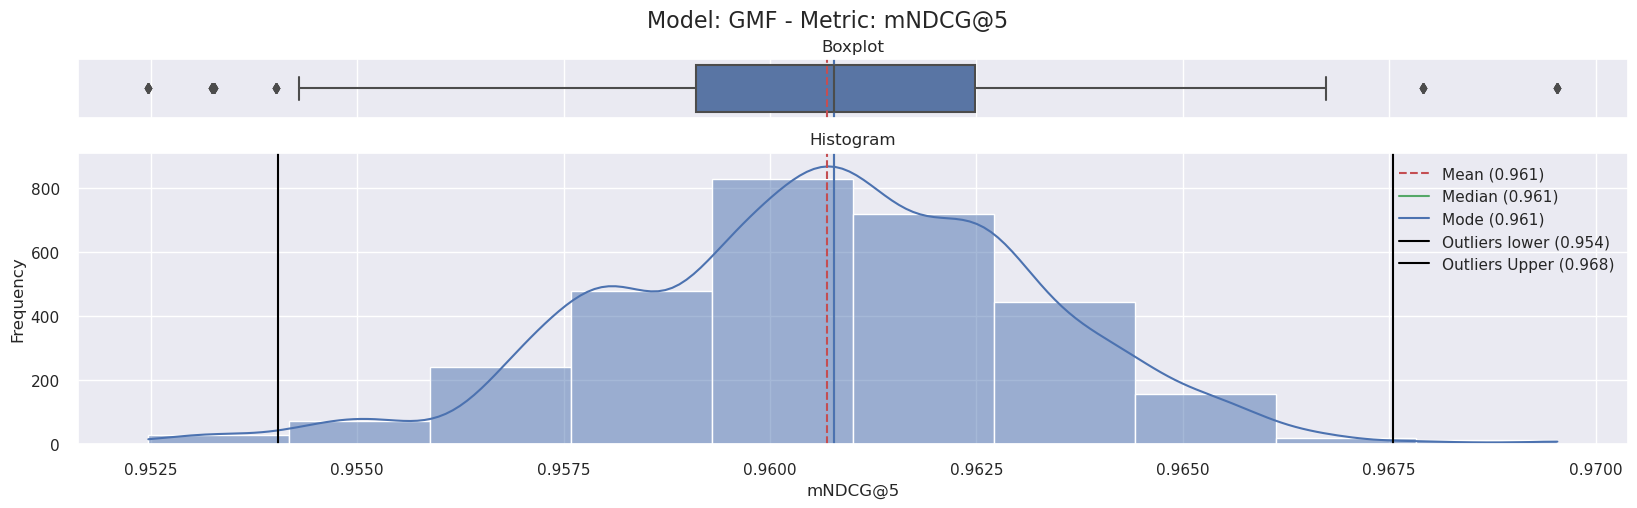

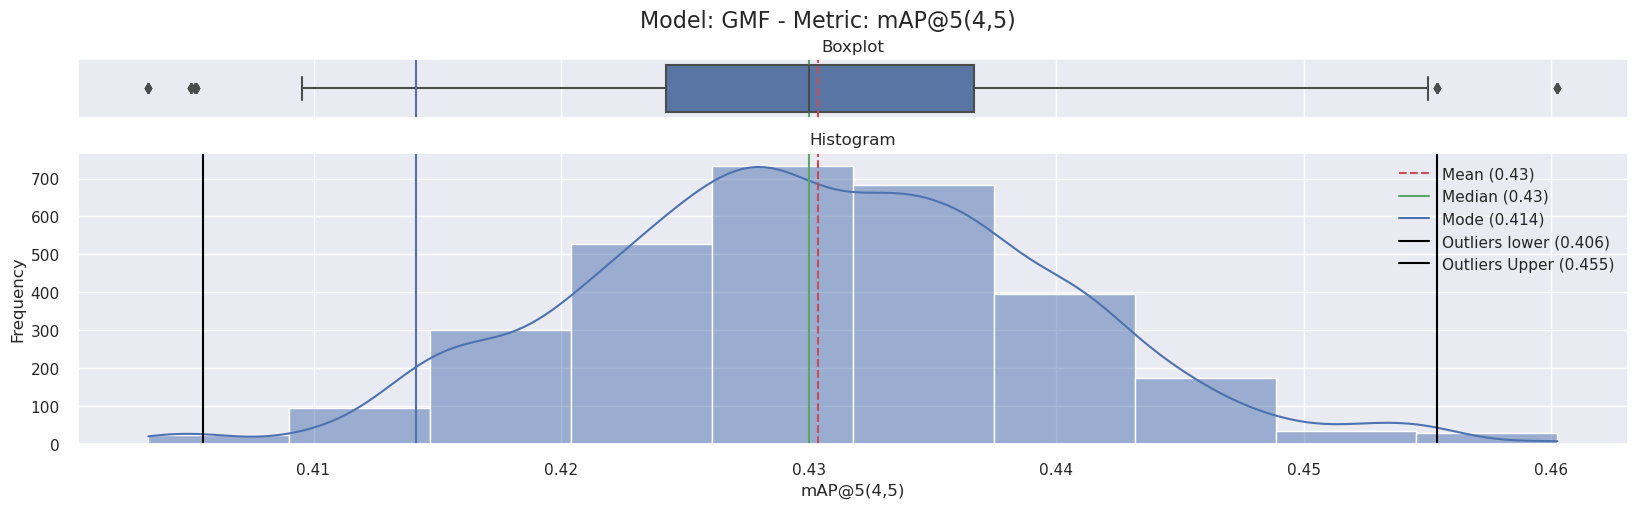

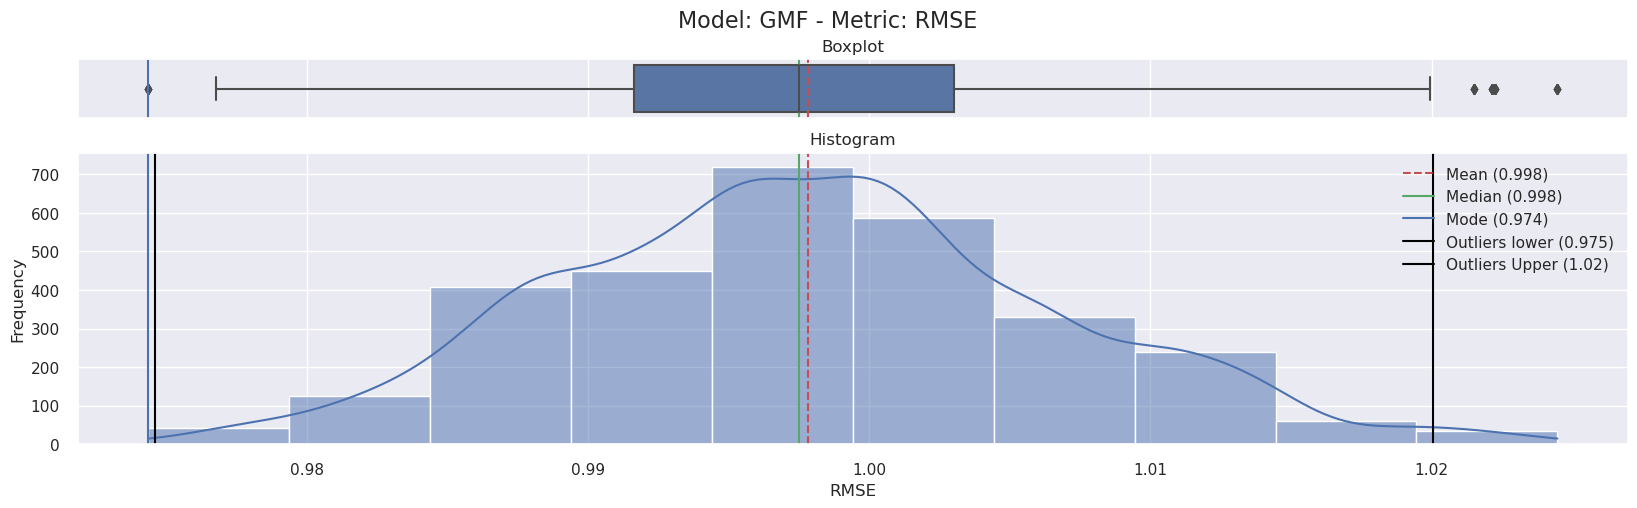

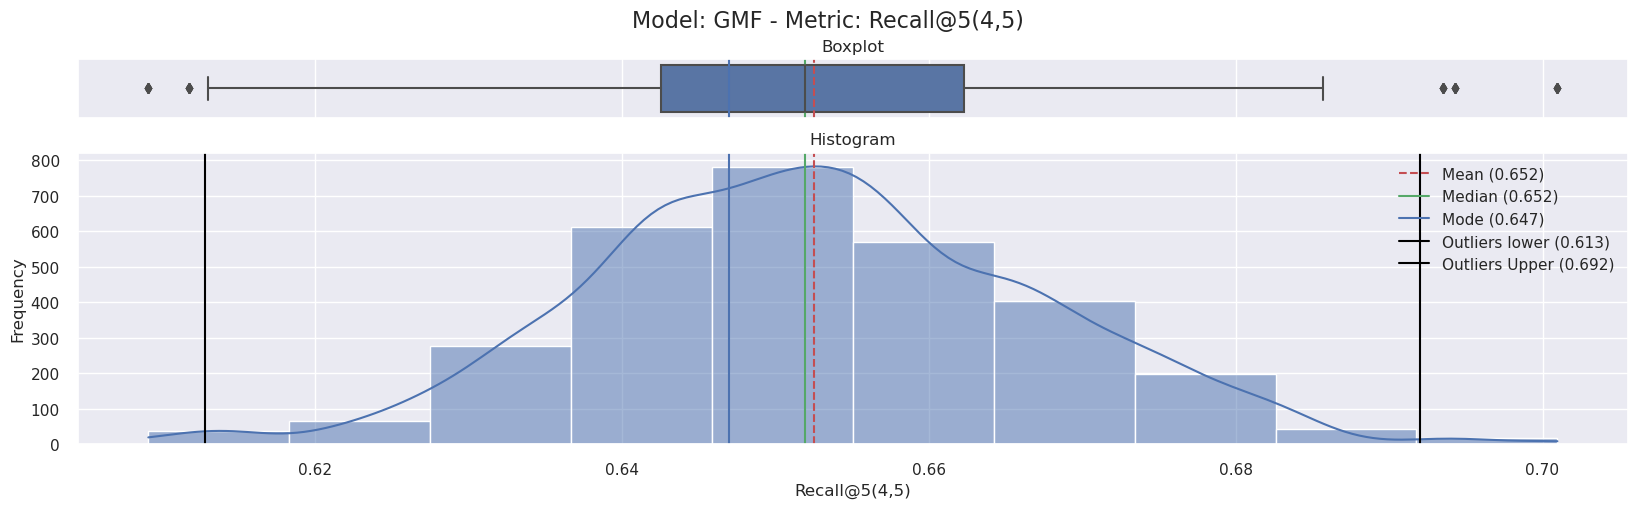

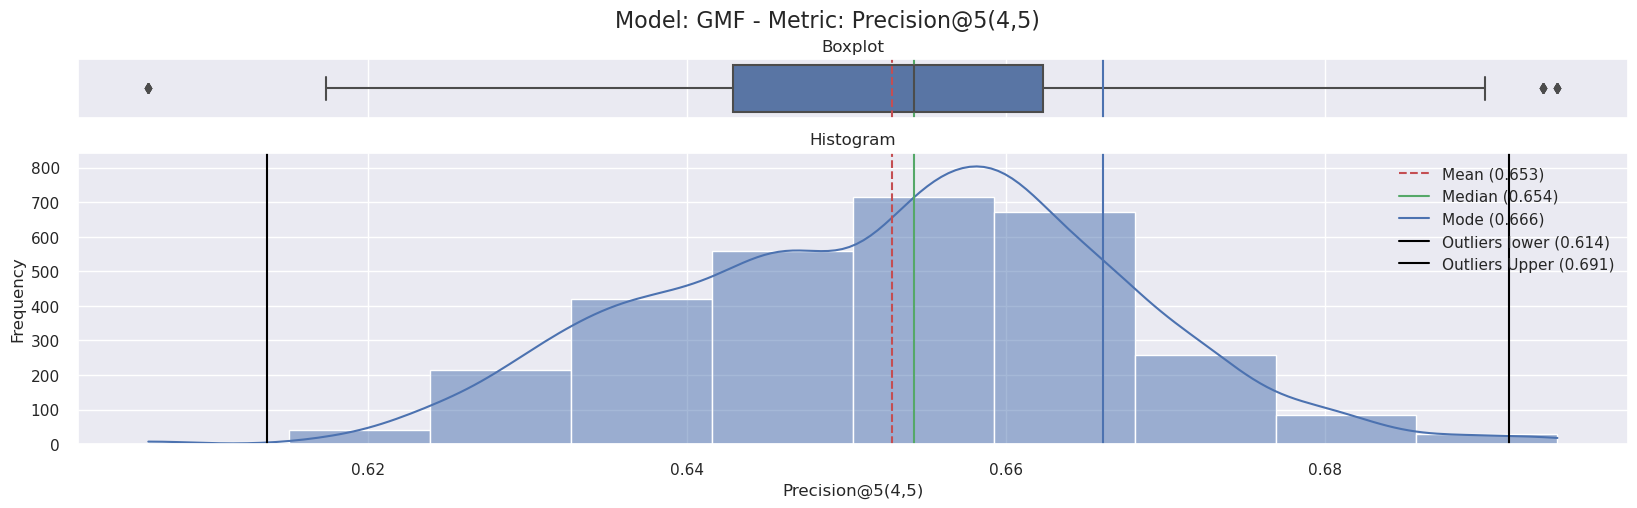

In [43]:
summary.plot()